# Practicing Neural Networks using Pytorch
___
Author: Simon Thornewill von Essen

Date: 16.08.2018
___

Now that I have written a network using Pytorch using the MNIST dataset. I want to write another network for a more difficult dataset, the F-MNIST. 

Here, I will be using the same techniques as before. I will be defining the model by an easier method than creating a network class so that it is easier to modify the code for fun and experimentation.

In [1]:
# Importing libraries
import torch
import helper # Might remove this
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch import nn
from torch import optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# Define Data Iterator
dataiter = iter(trainloader)

images, labels = dataiter.next()

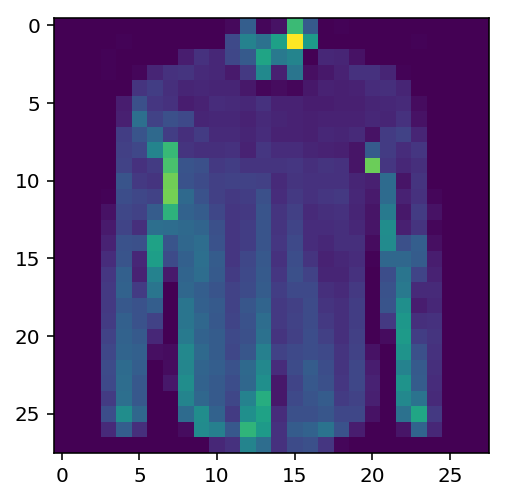

In [4]:
# Show an image from the Dataset
plt.imshow(images[0].numpy().squeeze());

In [5]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# Make an instance of Network class
model = Network(784, 10, [516, 256], drop_p=0.5)
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=516, bias=True)
    (1): Linear(in_features=516, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)

In [7]:
# Define loss and optimizer for training
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 2
steps = 0
print_every = 40 # Prints every 40 images, 64 images in a batch

In [8]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [10]:
for e in range(epochs):
    running_loss = 0
    model.train() # Technically not necessary, setting this for good measure
    for images, labels in trainloader:
        steps += 1
        
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval() # Turns off "Dropout", will make results look worse than they are
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 1.274..  Test Loss: 0.758..  Test Accuracy: 0.722
Epoch: 1/2..  Training Loss: 0.806..  Test Loss: 0.648..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.724..  Test Loss: 0.618..  Test Accuracy: 0.767
Epoch: 1/2..  Training Loss: 0.676..  Test Loss: 0.594..  Test Accuracy: 0.784
Epoch: 1/2..  Training Loss: 0.643..  Test Loss: 0.549..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.641..  Test Loss: 0.556..  Test Accuracy: 0.795
Epoch: 1/2..  Training Loss: 0.624..  Test Loss: 0.542..  Test Accuracy: 0.791
Epoch: 1/2..  Training Loss: 0.595..  Test Loss: 0.528..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.591..  Test Loss: 0.510..  Test Accuracy: 0.812
Epoch: 1/2..  Training Loss: 0.602..  Test Loss: 0.498..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.558..  Test Loss: 0.490..  Test Accuracy: 0.824
Epoch: 1/2..  Training Loss: 0.574..  Test Loss: 0.497..  Test Accuracy: 0.814
Epoch: 1/2..  Training Loss: 0.540..  Test Loss: 0.4

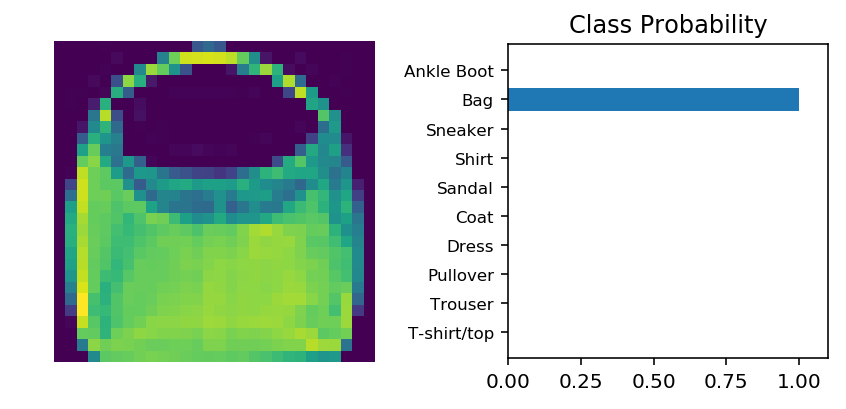

In [16]:
# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

___
After taking the time to train up an good network, we should also take the time to figure out how to save and import our networks so that we don't need to retrain every time we need to use the network to make a classification.

In [19]:
# Saving Model Architecture
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint/checkpoint.pth')

In [22]:
# fc_model is a package that contains the network outlined above in .py format
import fc_model

# Load Network with the following function
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [23]:
# Practice Loading Network
pretrained_model = load_checkpoint('checkpoint/checkpoint.pth')
pretrained_model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=516, bias=True)
    (1): Linear(in_features=516, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)